In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os
import sys
import numpy as np
import pandas as pd
import scipy.signal as sig
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath(r'C:/Users/mmccann/repos/bonhoeffer/prey_capture/'))

import paths
import processing_parameters
import functions_loaders as fl
import functions_data_handling as fdh
import functions_bondjango as bd
from functions_misc import list_lists_to_array

In [43]:
all_paths, all_queries = fl.query_search_list()
mice = ['_'.join(os.path.basename(path).split('_')[7:10]) for path in all_paths[0]]
print(all_paths)

data_list = []
# load the data
for path, queries in zip(all_paths, all_queries):
    
    data, _, metadata  = fl.load_preprocessing(path, queries, latents_flag=False)
    data_list.append(data)

frame_rate = processing_parameters.wf_frame_rate
kinem_vars = processing_parameters.variable_list_free


[['Z:\\Prey_capture\\AnalyzedData\\09_27_2023_15_50_10_VTuningWF_MM_230706_b_fullfield_free1_preproc.hdf5', 'Z:\\Prey_capture\\AnalyzedData\\09_27_2023_13_37_57_VTuningWF_MM_230706_a_fullfield_free1_preproc.hdf5', 'Z:\\Prey_capture\\AnalyzedData\\09_27_2023_12_30_21_VTuningWF_MM_230518_b_fullfield_free1_preproc.hdf5', 'Z:\\Prey_capture\\AnalyzedData\\09_25_2023_15_48_55_VTuningWF_MM_230518_b_repeat_light_free1_preproc.hdf5', 'Z:\\Prey_capture\\AnalyzedData\\09_25_2023_15_17_29_VTuningWF_MM_230518_b_repeat_light_free0_preproc.hdf5', 'Z:\\Prey_capture\\AnalyzedData\\09_25_2023_13_37_42_VTuningWF_MM_230706_a_repeat_light_free1_preproc.hdf5', 'Z:\\Prey_capture\\AnalyzedData\\09_25_2023_13_05_08_VTuningWF_MM_230706_a_repeat_light_free0_preproc.hdf5', 'Z:\\Prey_capture\\AnalyzedData\\09_25_2023_12_33_38_VTuningWF_MM_230706_b_repeat_light_free1_preproc.hdf5', 'Z:\\Prey_capture\\AnalyzedData\\09_25_2023_12_07_24_VTuningWF_MM_230706_b_repeat_light_free0_preproc.hdf5', 'Z:\\Prey_capture\\Analyze

# Test autocorrelation of kinematic variables

In [44]:
window_size = 10    # seconds

autocorr_dict = {}
for ds in data_list:
    ds = ds[0]
    ds.dropna(inplace=True)
    
    if 'wheel_speed' in ds.columns:
        ds['wheel_speed_abs'] = ds['wheel_speed'].abs()

    for kvar in kinem_vars:
        autocorr_list = []
        x = ds[kvar].to_numpy()

        if window_size == 'all':	
            xp = x - x.mean()
            result = sig.correlate(xp, xp, mode='full')
            result = result[result.size//2:] / np.var(x) / len(xp)
            autocorr_dict[kvar] = result

        else:
            # Parse the signal into chunks
            x = np.array_split(x, x.size//(window_size*frame_rate))
            for y in x:
                yp = y - y.mean()
                result = sig.correlate(yp, yp, mode='full')
                result = result[result.size//2:] / np.var(y) / len(yp)
                autocorr_list.append(result)

            autocorr_dict[kvar] = list_lists_to_array(autocorr_list)

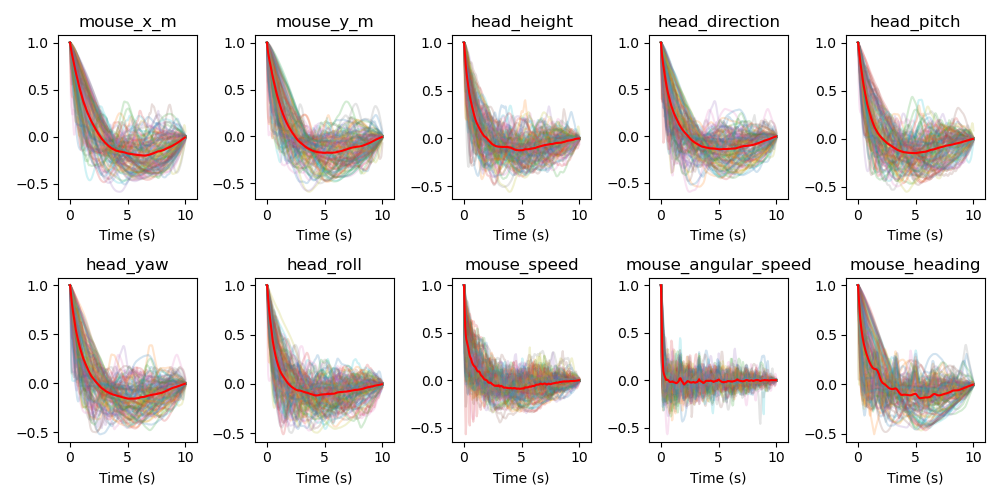

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

for ax, key in zip(axes.flatten(), autocorr_dict.keys()):
    autocorr = autocorr_dict[key]
    if window_size != 'all':
        ax.plot(np.arange(0, autocorr.shape[-1])/frame_rate, autocorr.T, alpha=0.2)
        ax.plot(np.arange(0, autocorr.shape[-1])/frame_rate, np.mean(autocorr, axis=0), color='r')
        ax.set_xlim(-1, window_size+1)

    else:
        ax.plot(np.arange(0, autocorr.shape[-1])/frame_rate, autocorr.T)

    ax.set_title(key)
    ax.set_xlabel('Time (s)')

plt.tight_layout()